This notebook implements different methods to interpret neural network decisions and applies them to Imagenet photos (in 2D) and MRI images from brains with Alzheimer's (the ADNI dataset, in 3D).

In [338]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import os

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

In [ ]:
from utils import load_nifti, plot_slices

# General

In [306]:
# Local
data_dir = 'data/adni-sample'

# Remote (Ubuntu)
#data_dir = '/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/'

# Remote (Mac)
#data_dir = '/Volumes/analysis/share/Fabi_Kerstin/AD_vs_HC_50_vs_49/'

In [313]:
# TODO: What does z_factor do here?
# Load a mask that is applied to all nifti images and strips the skull etc.
mask = load_nifti('data/WM_GM_mask.nii.gz', z_factor=0.75)

In [314]:
e = 1e-6  # small perturbation to prevent zero division

# Apply methods to Imagenet photos (2D)

In [450]:
model = models.alexnet(pretrained=True)
#model = models.inception_v3(pretrained=True)  # raises an error when predicting
#model = models.vgg19_bn(pretrained=True)

In [458]:
list(list(model.children())[0].children())

[Conv2d (3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1)),
 Conv2d (64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1)),
 Conv2d (192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d (384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1))]

In [4]:
valdir = 'data/images'

image_means = np.array([0.485, 0.456, 0.406])
image_stds = np.array([0.229, 0.224, 0.225])

normalize = transforms.Normalize(mean=image_means, std=image_stds)

val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Scale(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=64, shuffle=False,
        num_workers=1, pin_memory=True)

In [5]:
def image_tensor_to_rgb(image_tensor):
    '''Convert a normalized image tensor to an RGB array (that can be displayed via pyplot.imshow).'''
    image = image_tensor.numpy() * image_stds.reshape(3, 1, 1) + image_means.reshape(3, 1, 1)
    image = image.transpose(1, 2, 0)
    return image

def get_image(index):
    image_tensor = val_loader.dataset[index][0]
    return image_tensor_to_rgb(image_tensor), image_tensor

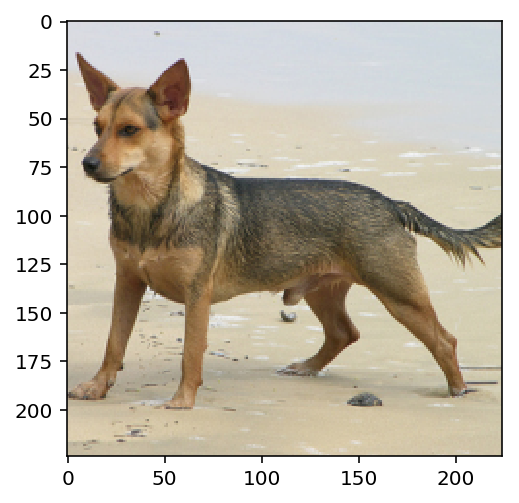

In [6]:
plt.imshow(get_image(0)[0])

In [7]:
# To get the same results as in pytorch-cnn-visualizations (https://github.com/utkuozbulak/pytorch-cnn-visualizations),
# set a fixed target class and do `postprocess=None`.

def sensitivity_analysis(model, image_tensor, target=None, postprocess='abs'):
    # image_tensor can be a pytorch tensor or anything that can be converted to a pytorch tensor (e.g. numpy, list)
    
    image_tensor = torch.Tensor(image_tensor)  # convert numpy or list to tensor
    X = Variable(image_tensor[None], requires_grad=True)  # add dimension to simulate batch
    
    model.eval()
    output = model(X)
    output_class = output.max(1)[1].data.numpy()[0]
    print('Image was classified as:', output_class)
    
    model.zero_grad()
    one_hot_output = torch.zeros(output.size())
    if target is None:
        one_hot_output[0, output_class] = 1
    else:
        one_hot_output[0, target] = 1
    output.backward(gradient=one_hot_output)
        
    relevance_map = X.grad.data[0].numpy()
    
    if postprocess == 'abs':  # as in Simonyan et al. (2013)
        return np.abs(relevance_map)
    elif postprocess == 'square':  # as in Montavon et al. (2018)
        return relevance_map**2
    elif postprocess is None:
        return relevance_map
    else:
        raise ValueError()
    
def taylor_decomposition(model, image_tensor, target=None):
    relevance_map = sensitivity_analysis(model, image_tensor, target=target)
    
    try:
        image_tensor = image_tensor.numpy()  # if it's a pytorch tensor
    except AttributeError:
        image_tensor = np.asarray(image_tensor)  # if it's a list or anything else
    
    return relevance_map * image_tensor.max(axis=0)  # TODO: How to deal with the several color channels of the image?

In [8]:
def guided_backprop(model, image_tensor, target=None, postprocess='abs'):
    
    def relu_hook_function(module, grad_in, grad_out):
        """
        If there is a negative gradient, change it to zero.
        """
        if isinstance(module, nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.0),)
        
    hook_handles = []
    
    try:
        # Loop through layers, hook up ReLUs with relu_hook_function, store handles to hooks.
        for pos, module in model.features._modules.items():
            if isinstance(module, nn.ReLU):
                hook_handle = module.register_backward_hook(relu_hook_function)
                hook_handles.append(hook_handle)

        # Calculate backprop with modified ReLUs.
        relevance_map = sensitivity_analysis(model, image_tensor, target=target, postprocess=postprocess)
        
    finally:
        # Remove hooks from model.
        # The finally clause re-raises any possible exceptions.
        for hook_handle in hook_handles:
            hook_handle.remove()
            del hook_handle
        
    return relevance_map

In [9]:
from pytorch_cnn_visualizations.vanilla_backprop import VanillaBackprop
from pytorch_cnn_visualizations.guided_backprop import GuidedBackprop
from pytorch_cnn_visualizations.misc_functions import convert_to_grayscale

Image was classified as: 232
Image was classified as: 232
Image was classified as: 232
Image was classified as: 249
Image was classified as: 249
Image was classified as: 249
Image was classified as: 947
Image was classified as: 947
Image was classified as: 947
Image was classified as: 27
Image was classified as: 27
Image was classified as: 27


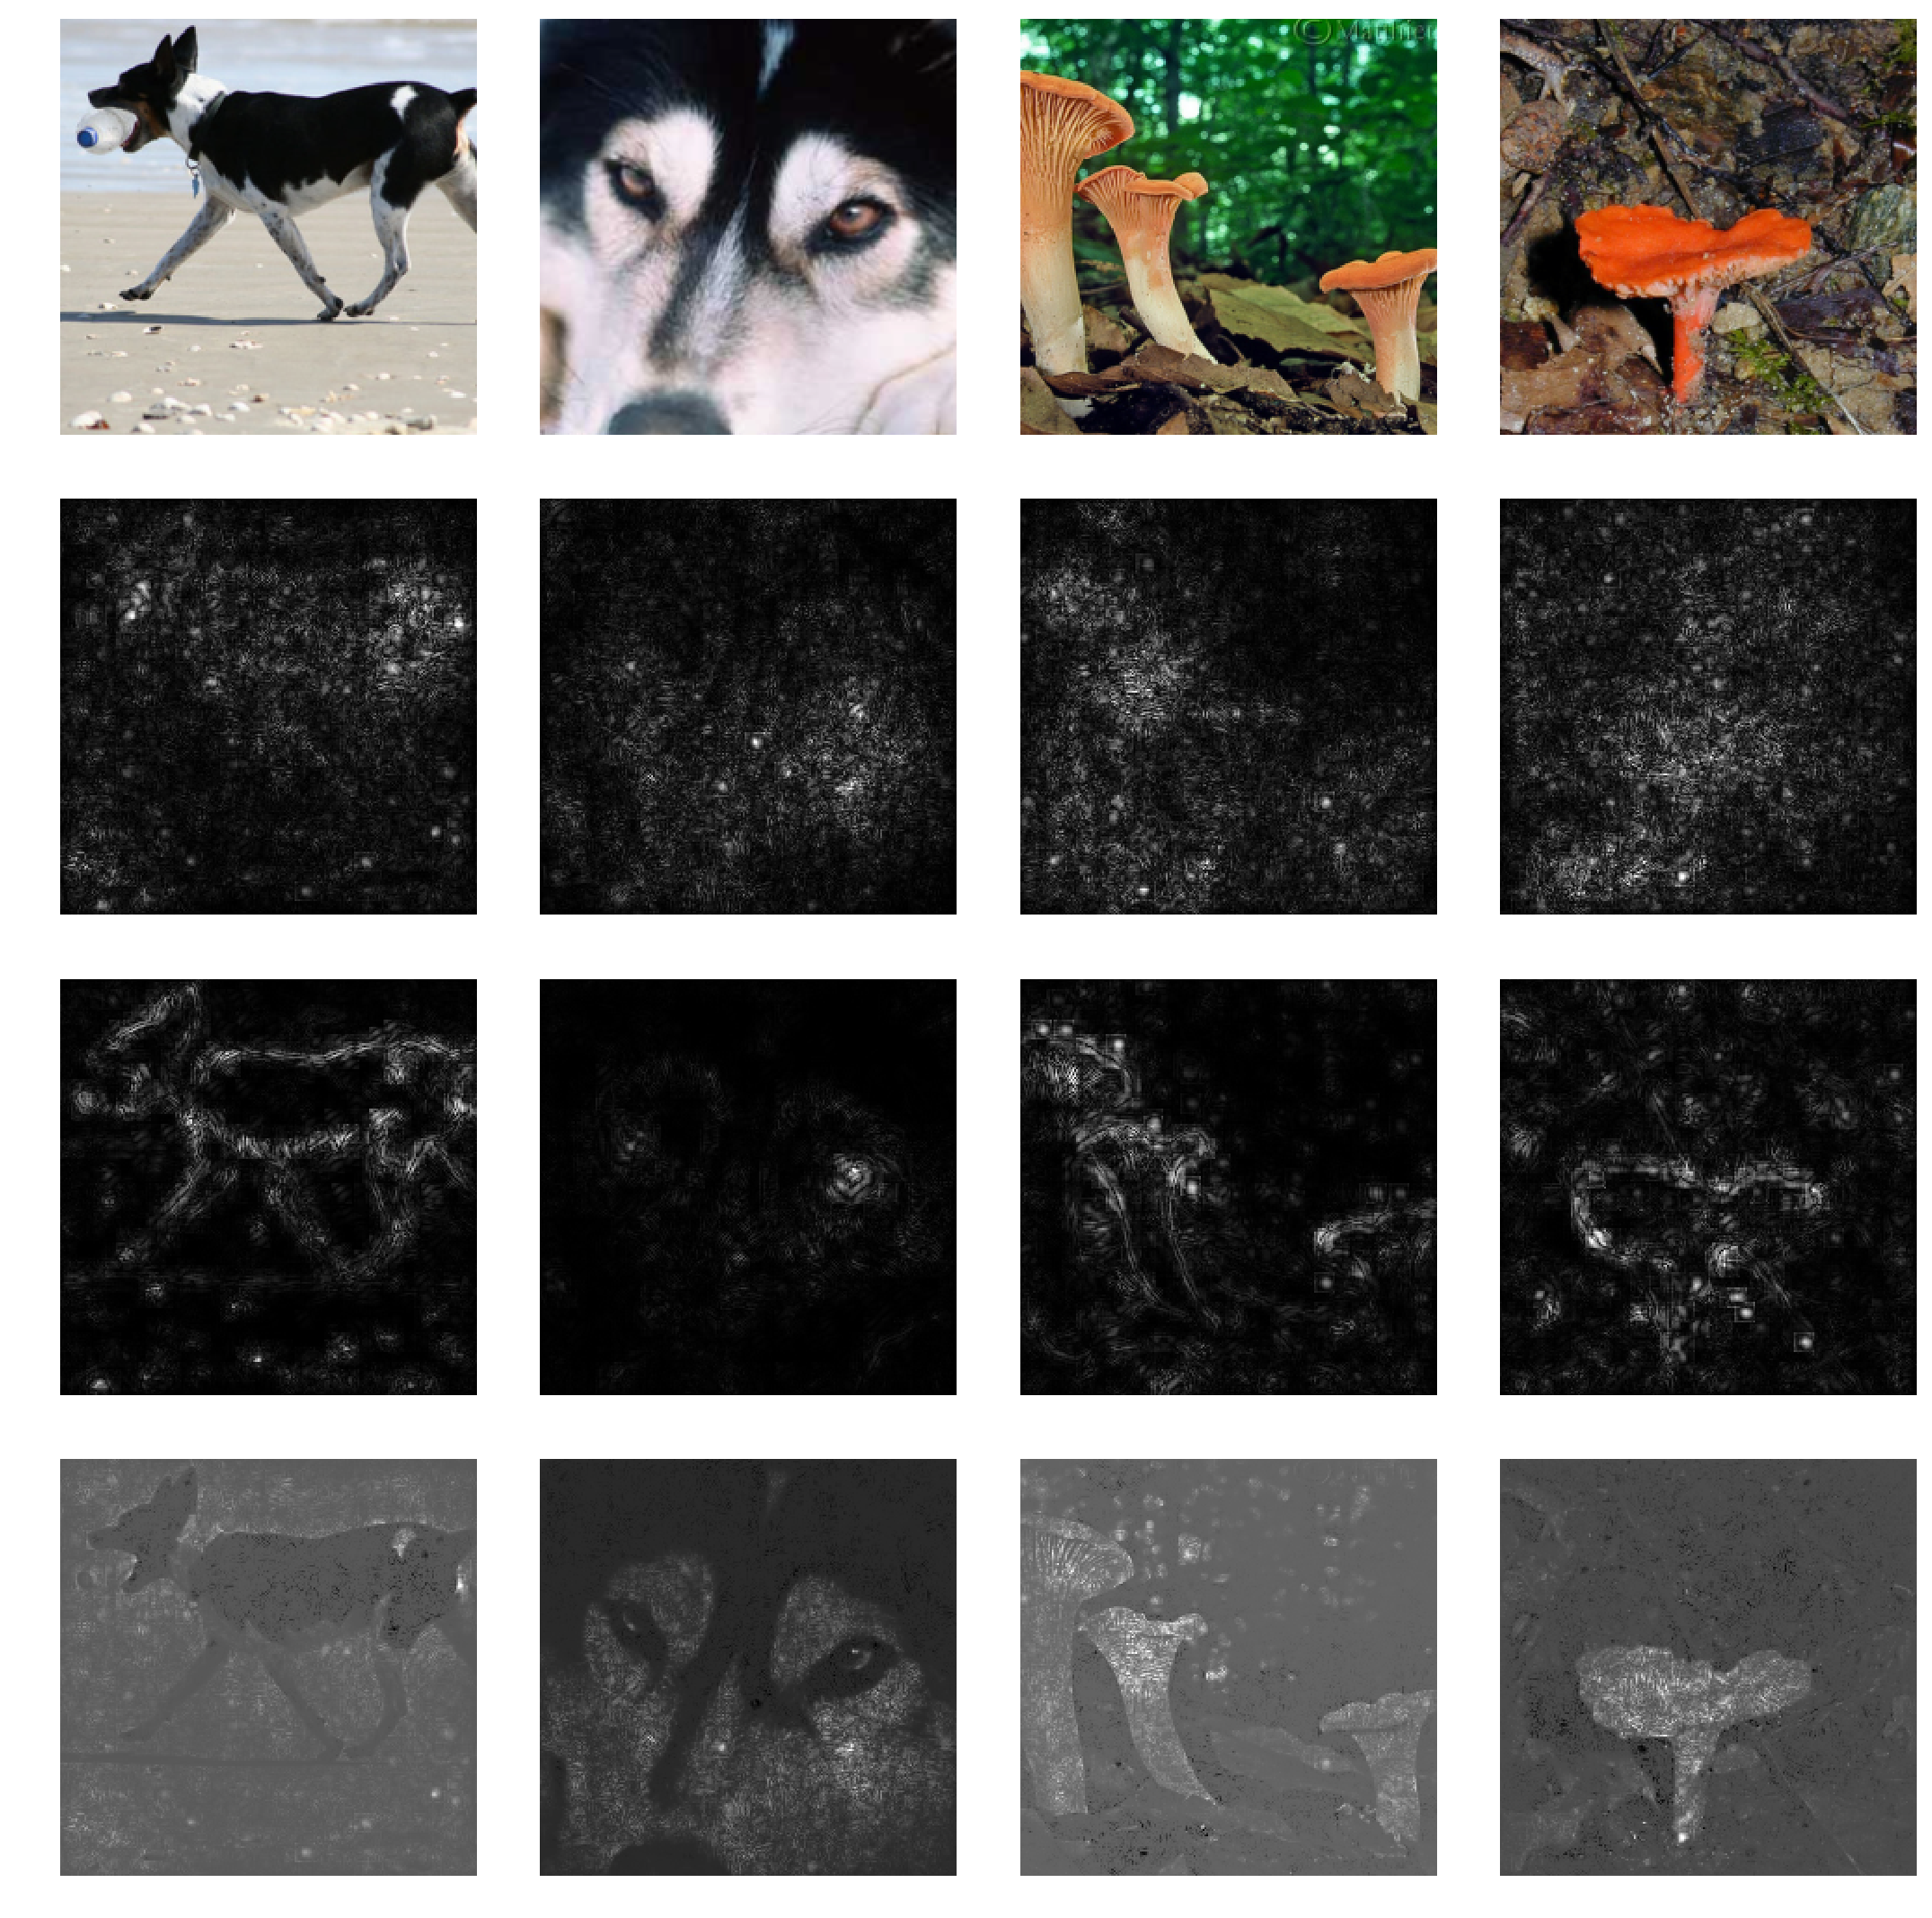

In [10]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

offset = 2

for i, vertical_axes in enumerate(axes.T):
    image, image_tensor = get_image(i+offset)
    
    plt.sca(vertical_axes[0])
    plt.axis('off')
    plt.imshow(image)
    
    plt.sca(vertical_axes[1])
    plt.axis('off')
    plt.imshow(sensitivity_analysis(model, image_tensor, postprocess='abs').max(0), cmap='Greys_r')
    
    #plt.sca(vertical_axes[2])
    #plt.axis('off')
    #vbp = VanillaBackprop(model, Variable(image_tensor[None], requires_grad=True), 227)
    #vbp_heatmap = vbp.generate_gradients()
    #plt.imshow(vbp_heatmap.max(0), cmap='Greys_r')
    
    plt.sca(vertical_axes[2])
    plt.axis('off')
    # TODO: Investigate why my methods are different from the package.
    # Possible reasons: target class, true one-hot vector, abs postprocessing, gradient w.r.t parameters vs input
    plt.imshow(guided_backprop(model, image_tensor, postprocess='abs').max(0), cmap='Greys_r')
    
    #plt.sca(vertical_axes[4])
    #plt.axis('off')
    # TODO: Target class.
    #gbp = GuidedBackprop(model, Variable(image_tensor[None], requires_grad=True), 227)
    #gbp_heatmap = gbp.generate_gradients()
    #plt.imshow(gbp_heatmap.max(0), cmap='Greys_r')
    #gbp.unhook()
    
    plt.sca(vertical_axes[3])
    plt.axis('off')
    plt.imshow(taylor_decomposition(model, image_tensor).max(0), cmap='Greys_r')

plt.tight_layout()

- 1st row: Image
- 2nd row: Vanilla Backprop (mine)
- 3th row: Guided Backprop (mine)
- 4th row: Taylor Decomposition (mine)

# Apply methods to ADNI data (3D)

In [322]:
# TODO: These are adapted from above in order to deal with binary output instead of softmax. Generalize this.

def sensitivity_analysis(model, image_tensor, target=None, postprocess='abs', output_mode=None):
    # image_tensor can be a pytorch tensor or anything that can be converted to a pytorch tensor (e.g. numpy, list)
    
    if output_mode not in [None, 'binary', 'categorical']:
        raise ValueError("output_mode must be None, 'binary' or 'categorical'")
    if postprocess not in [None, 'abs', 'square']:
        raise ValueError("postprocess must be None, 'abs' or 'sqaure'")
    
    # Forward pass.
    image_tensor = torch.Tensor(image_tensor)  # convert numpy or list to tensor
    X = Variable(image_tensor[None], requires_grad=True)  # add dimension to simulate batch
    model.eval()
    output = model(X)
    
    # Backward pass.
    model.zero_grad()
    if output_mode is None:
        output_mode = 'binary' if output.size(1) == 1 else 'categorical'
    if output_mode == 'binary':  # binary output
        # TODO: Does it make sense to always use one here as the output gradient? 
        #       (This is similar to using one-hot below.)
        print('Image was classified as:', output.data.numpy()[0, 0].round())
        output.backward(gradient=torch.ones(output.size()))
    elif output_mode == 'categorical':  # categorical output
        output_class = output.max(1)[1].data.numpy()[0]
        print('Image was classified as:', output_class)
        # TODO: Check if setting to one hot makes sense here.
        one_hot_output = torch.zeros(output.size())
        if target is None:
            one_hot_output[0, output_class] = 1
        else:
            one_hot_output[0, target] = 1
        output.backward(gradient=one_hot_output)
        
    relevance_map = X.grad.data[0].numpy()
    
    # Postprocess the relevance map.
    if postprocess == 'abs':  # as in Simonyan et al. (2013)
        return np.abs(relevance_map)
    elif postprocess == 'square':  # as in Montavon et al. (2018)
        return relevance_map**2
    elif postprocess is None:
        return relevance_map
        
        
def guided_backprop(model, image_tensor, target=None, postprocess='abs', output_mode=None):
    
    def relu_hook_function(module, grad_in, grad_out):
        """
        If there is a negative gradient, change it to zero.
        """
        if isinstance(module, nn.ELU):
            return (torch.clamp(grad_in[0], min=0.0),)
        
    hook_handles = []
    
    try:
        # Loop through layers, hook up ReLUs with relu_hook_function, store handles to hooks.
        #for pos, module in model.features._modules.items():
        for module in model.children():
            if isinstance(module, nn.ELU):
                print('Registered hook for layer:', module)
                hook_handle = module.register_backward_hook(relu_hook_function)
                hook_handles.append(hook_handle)

        # Calculate backprop with modified ReLUs.
        relevance_map = sensitivity_analysis(model, image_tensor, target=target, postprocess=postprocess, output_mode=output_mode)
        
    finally:
        # Remove hooks from model.
        # The finally clause re-raises any possible exceptions.
        print('Removing {} hook(s)'.format(len(hook_handles)))
        for hook_handle in hook_handles:
            hook_handle.remove()
            del hook_handle
        
    return relevance_map

In [323]:
net = torch.load('data/models/model_121217_1_converted_to_pytorch.p')

In [324]:
# TODO: This is a dirty workaround and only calculates the std across 10 images. Implement a nice way to get the std and mean across all samples.
# TODO: Do not actually calculate these values here, but preserve them somewhere.
all_struct_arr = np.zeros((10, 91, 109, 91))
for i, filename in enumerate(os.listdir(data_dir)[:10]):
    struct_arr = load_nifti(os.path.join(data_dir, filename), mask=mask)
    all_struct_arr[i] = struct_arr
    
pixel_std = all_struct_arr.std(0)

In [329]:
struct_arr = load_nifti('data/adni-sample/AD_0003_wT1.nii', mask=mask)
struct_arr = struct_arr / (pixel_std + e)
struct_arr = struct_arr[None]  # add (empty) channel dimension
struct_arr = torch.from_numpy(struct_arr).float()

X = struct_arr

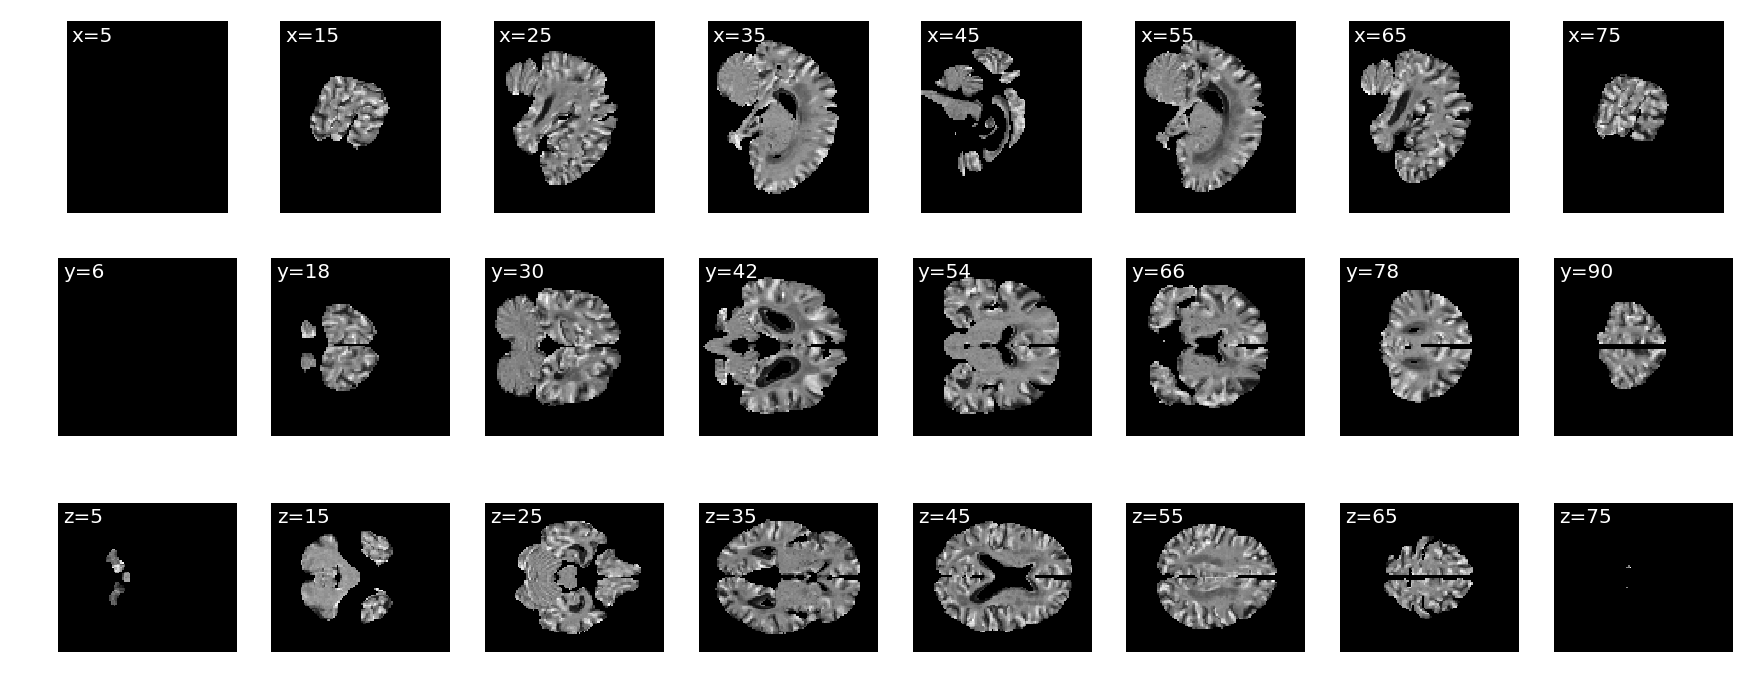

In [331]:
plot_slices(X[0])

In [332]:
relevance_map = sensitivity_analysis(net, X)
relevance_map.shape

Image was classified as: 1.0


(1, 91, 109, 91)

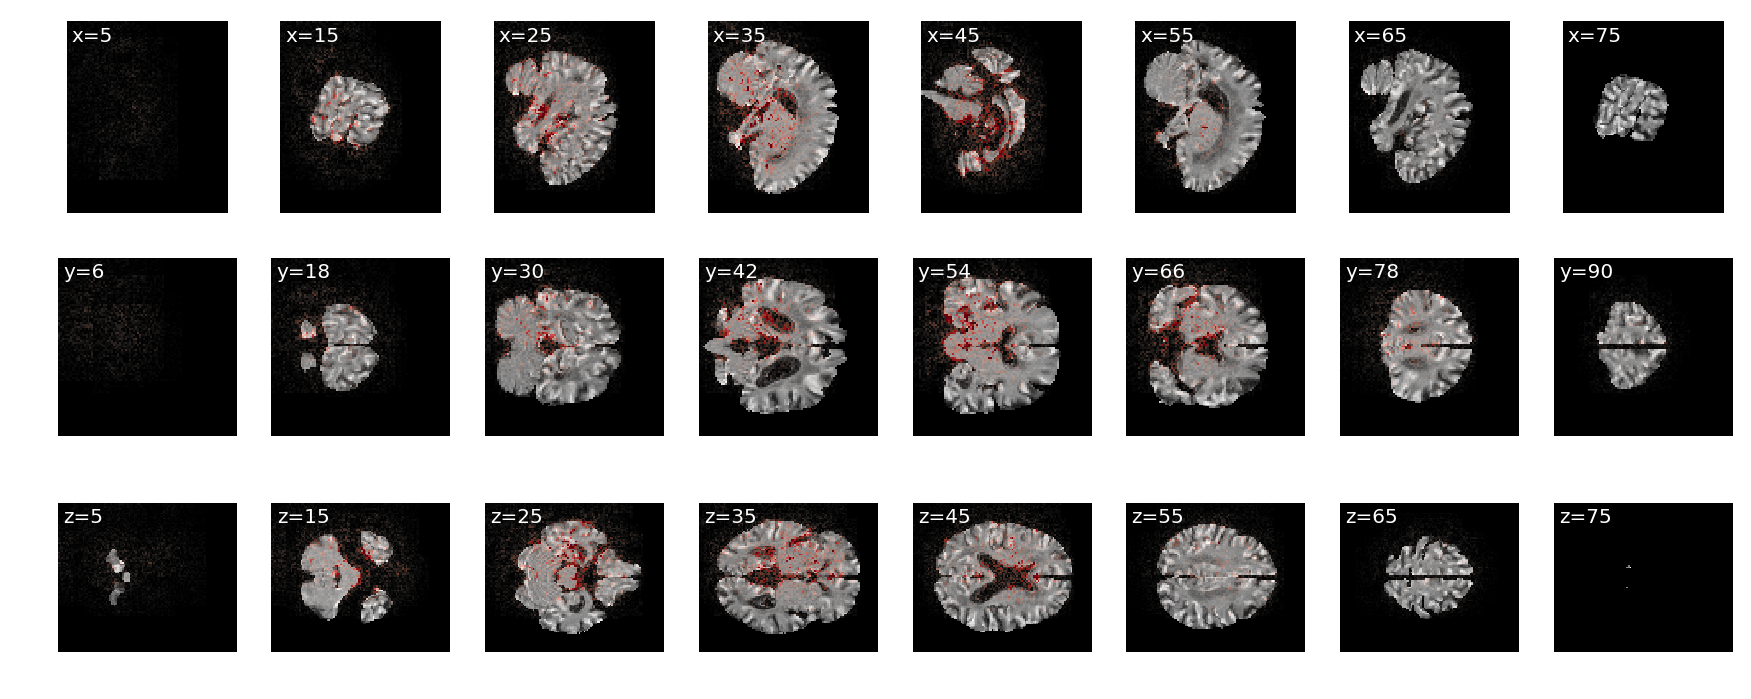

In [333]:
plot_slices(X[0], overlay=relevance_map[0], overlay_vmax=np.percentile(relevance_map, 99.9))

In [336]:
relevance_map = guided_backprop(net, X)
relevance_map.shape

Registered hook for layer: ELU(alpha=1.0)
Image was classified as: 1.0
Removing 1 hook(s)


(1, 91, 109, 91)

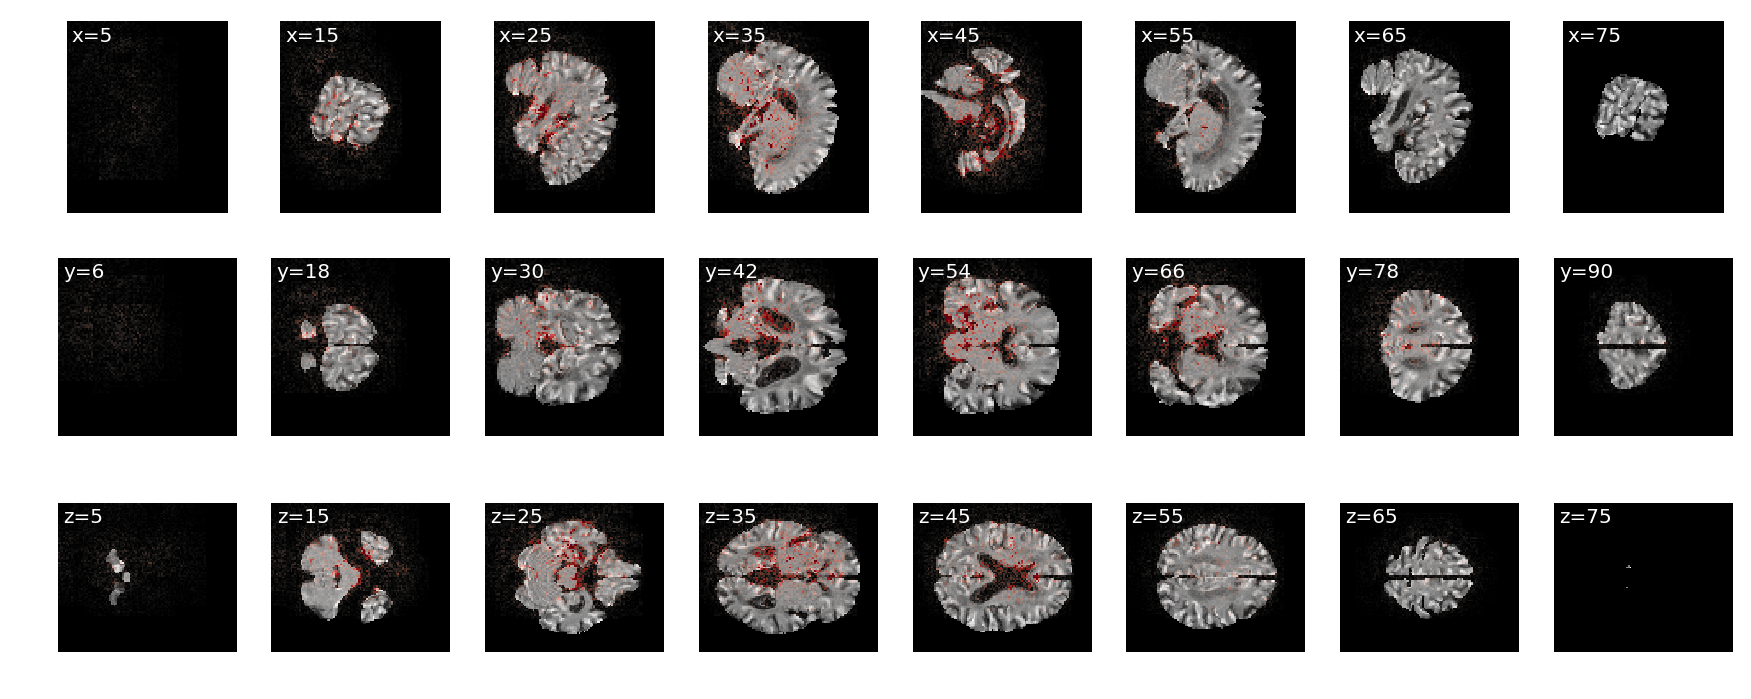

In [337]:
# TODO: Results are equal to normal backprop (they were different/better before the refactoring!).
plot_slices(X[0], overlay=relevance_map[0], overlay_vmax=np.percentile(relevance_map, 99.9))

# Traverse pytorch model
This is some preliminary exploration, but might be needed to implement LRP.

In [137]:
from graphviz import Digraph
import torch
from torch.autograd import Variable


def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph
    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function
    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    #dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                print('Tensor:', str(id(var)), size_to_str(var.size()))
                #dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
                pass
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                print('Variable: ', str(id(var)), node_name)
                #dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                print('Whatever: ', str(id(var)), str(type(var).__name__))
                #dot.node(str(id(var)), str(type(var).__name__))
                pass
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        #dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    #dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    #return dot

In [138]:
make_dot(out)

Whatever:  4548426488 SigmoidBackward
Whatever:  4548426240 AddmmBackward
Variable:  4557421072 
 (1)
Whatever:  4548425744 ViewBackward
Whatever:  4548425496 MaxPool3dBackward
Whatever:  4548425248 ELUBackward
Whatever:  4551987600 ConvNdBackward
Whatever:  4548425000 ELUBackward
Whatever:  4551987344 ConvNdBackward
Whatever:  4548424752 MaxPool3dBackward
Whatever:  4548424504 ELUBackward
Whatever:  4551990608 ConvNdBackward
Whatever:  4548424256 MaxPool3dBackward
Whatever:  4548424008 ELUBackward
Whatever:  4551987984 ConvNdBackward
Variable:  4551989392 
 (64, 1, 3, 3, 3)
Variable:  4551988944 
 (64)
Tensor: 4955330608 (1, 64, 89, 107, 89)
Tensor: 4559218664 (1, 64, 89, 107, 89)
Tensor: 4574505080 (1, 64, 89, 107, 89)
Tensor: 4574505512 (1, 64, 29, 35, 29)
Variable:  4551988496 
 (64, 64, 3, 3, 3)
Variable:  4551990928 
 (64)
Tensor: 4574504000 (1, 64, 27, 33, 27)
Tensor: 4574506016 (1, 64, 27, 33, 27)
Tensor: 4574503352 (1, 64, 27, 33, 27)
Tensor: 4574506304 (1, 64, 9, 11, 9)
Varia

In [158]:
def traverse(node, indent='  '):
    #if torch.is_tensor(node): print('tensor')
    if not hasattr(node, 'variable'):
        
        print(indent, node)
        if node is not None:
            for next_node_tuple in node.next_functions:
                traverse(next_node_tuple[0], indent+'  ')
        
        
traverse(out.grad_fn)

                               None


In [144]:
out.grad_fn.next_functions[0][0].grad_fn

AttributeError: 'AddmmBackward' object has no attribute 'grad_fn'